In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %qtconsole
from IPython.display import display, HTML

# initiate settings

In [2]:
import pandas as pd
import os
import numpy as np
import pylab as plt
from pylab import show
import re
from utils import vector_dist, digitize, roll_window_regardless_values, multivector_dist
from scipy.stats import ks_2samp

from pylab import savefig, rcParams
rcParams['legend.loc'] = 'best'

from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

BASE_DIR = r"D:\Users\Mojo\Google Drive\Technion\project - astrophysics"
DATA_DIR = os.path.join(BASE_DIR, "raw_data")
GRAPHS_DIR = os.path.join(BASE_DIR, "graphs")
pd.set_option('display.width', 1000)

# import stars and planets table

In [3]:
#### stars table ###
stars_path = os.path.join(DATA_DIR, "stars.xlsx")
stars_raw = pd.read_excel(stars_path)
# clean stars with not Age or Teff
stars_raw = stars_raw[stars_raw.Age.notnull()]
stars_raw = stars_raw[stars_raw.Teff.notnull()]
print "Stars:", stars_raw.shape

### planets table ###
planets_path = os.path.join(DATA_DIR, "planets.xlsx")
planets = pd.read_excel(planets_path)
p_raw = planets
num_rows = p_raw.shape[0]
print "Read {:d} planets from file {:s}".format(num_rows, "planets.xlsx")

Stars: (34886, 11)
Read 4706 planets from file planets.xlsx


# cleaning, binning (Teff)

In [4]:
def dffilter(df, condition, num_rows, condition_text=""):
    df = df[condition]
    print "Dropped {:d} rows {:s}".format(num_rows - df.shape[0], condition_text)
    num_rows = df.shape[0]
    print "Num rows: {:d}".format(num_rows)
    return df, num_rows

print "Cleaning planets..."
# only deal with planets with age and temperature
p_raw, num_rows = dffilter(p_raw, p_raw.Age.notnull() & p_raw.Teff.notnull(), 
                           num_rows, "without Age or Teff")
# remove those planets with uncertain temperature (temp-diff < 400K)
p_raw, num_rows = dffilter(p_raw, p_raw.teff_34030_8826_diff.fillna(0) < 400,
                           num_rows, "with teff_34030_8826_diff > 400 (undefined temperature)")
# remove planets with wrong period
p_raw, num_rows = dffilter(p_raw, p_raw.koi_period < 5000, 
                           num_rows, "with koi_period > 5000 days")
# remove planets with huge planetary-radius
p_raw, num_rows = dffilter(p_raw, p_raw.koi_prad < 15, 
                           num_rows, "with koi_prad > 15")


Cleaning planets...
Dropped 3382 rows without Age or Teff
Num rows: 1324
Dropped 22 rows with teff_34030_8826_diff > 400 (undefined temperature)
Num rows: 1302
Dropped 1 rows with koi_period > 5000 days
Num rows: 1301
Dropped 60 rows with koi_prad > 15
Num rows: 1241


## Filtering

Dropped 0 rows with Age > 5000Myr
Num rows: 491
Dropped 0 rows with koi_period > 10
Num rows: 491
KOI Period median: 4.790915598
KOI Period mean: 4.9623687876
Dropped 0 rows with koi_prad < 0.5
Num rows: 491


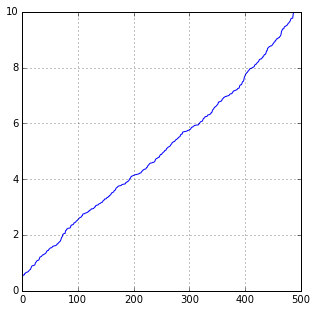

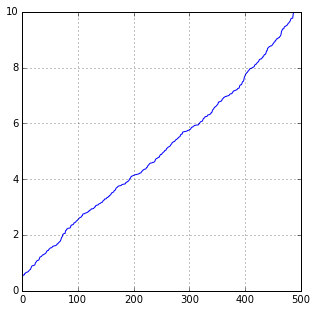

In [35]:
# the statistics become really small anyways for planets older than 5000Myr
age_limit = 5000
p_raw, num_rows = dffilter(p_raw, p_raw.Age < age_limit, 
                           num_rows, "with Age > 5000Myr")

# This is to remove selection bias (up to 30 days the bias of the size should be small)
vector_dist(p_raw.koi_period)

p_raw, num_rows = dffilter(p_raw, p_raw.koi_period < 10, 
                           num_rows, "with koi_period > 10")

vector_dist(p_raw.koi_period)

print "KOI Period median:", p_raw.koi_period.median()
print "KOI Period mean:", p_raw.koi_period.mean()


# remove planets with p-rad bigger than earth-size (to avoid selection bias)
p_raw, num_rows = dffilter(p_raw, p_raw.koi_prad > 0.5, 
                           num_rows, "with koi_prad < 0.5")



stars = stars_raw
p = p_raw

## Binning

In [36]:
###################################################################
#          Bin systems according to temperatures                  #
###################################################################
systems = p[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
print "Systems num:", systems.shape[0]
teff_categories, teff_qbins = pd.qcut(systems.Teff.values, 4, retbins=True)

Systems num: 407


# Define dataframes (bigger/smaller than threshold)

In [37]:
# Based on the above results, especially the one frequency charts,
# the main conclusion is that the frequency of planets close to the star increases with age.
# CHECK WITH HAGAI: That might lead to a model that with time, planets get closer to the star
# because of angular-momentum transfer to the star. That should only occur with planets close enough to the star.
# If this is true, we would expect to see a non-increasing frequency with planets farther from the star

# define df for planets smaller-bigger than threshold

threshold = 7.0
thresh_type = 'period'
thresh_unit = 'days'
pg = p[p.koi_period > threshold]
pl = p[p.koi_period < threshold]

# threshold = 0.06
# thresh_type = 'sma'
# thresh_unit = 'AU'
# pg = p[p.koi_sma > threshold]
# pl = p[p.koi_sma < threshold]


# define systems-df for each planets-df
systems_g = pg[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
systems_g['multiplicity'] = pg.groupby('KIC').size()
systems_g['teff_bins'] = digitize(systems_g.Teff, teff_qbins)
print "Systems-G num:", systems_g.shape[0]
systems_l = pl[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
systems_l['multiplicity'] = pl.groupby('KIC').size()
systems_l['teff_bins'] = digitize(systems_l.Teff, teff_qbins)
print "Systems-L num:", systems_l.shape[0]


Systems-G num: 118
Systems-L num: 327


### Check if there's a difference in temp (mass) distribution between >7 and < 7

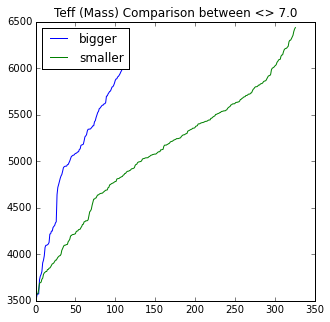

In [38]:
multivector_dist([systems_g.Teff, systems_l.Teff], 
                 title="Teff (Mass) Comparison between <> {}".format(threshold), 
                 labels=["bigger","smaller"])

In [39]:
# Multiplicities of host-systems in the intersection of bigger-smaller
# This is just a verification that we are actually dealing with different planets 
# (If the intersection of planets is not empty we are in a problem...)

kic_i = systems_g.index.intersection(systems_l.index).values
systems_g.loc[kic_i].sort()
systems_l.loc[kic_i].sort()

print "Sanity Check"
print "is the intersection of Bigger-smaller empty?"
print "Total systems in intersection (have planets both in bigger and smaller):", kic_i.shape[0]
print "bigger hist:"
print systems_g.loc[kic_i].multiplicity.value_counts()
print "smaller hist:"
print systems_l.loc[kic_i].multiplicity.value_counts()

print "If the histograms are different than it's fine (it's not the same intersection..)"


Sanity Check
is the intersection of Bigger-smaller empty?
Total systems in intersection (have planets both in bigger and smaller): 38
bigger hist:
1    37
2     1
dtype: int64
smaller hist:
1    28
2     8
3     2
dtype: int64
If the histograms are different than it's fine (it's not the same intersection..)


## Estimate Densities of planets

In [40]:
def flat_systems_ages(df):
    """
    Gets a dataframe of systems, each systems might have more than one planet (depend on its multiplicity)
    For each system, "flattens" it to have multiplicity-times its age
    """    
    ages = np.zeros(df[df.Age <= age_limit].multiplicity.sum())
    i = 0
    for ind in xrange(df.shape[0]):
        for age in [df.iloc[ind].Age] * df.iloc[ind].multiplicity:
            if df.iloc[ind].Age > age_limit: continue
            ages[i] = df.iloc[ind].Age
            i += 1
    return ages
    
# Overall densities
g_ages = flat_systems_ages(systems_g)
l_ages = flat_systems_ages(systems_l)
all_stars_ages = stars[stars.Age < age_limit].Age.values
# Teff bins
g_bins_ages = []
l_bins_ages = []
for teff_bin in xrange(len(teff_categories.categories)):
    qg = systems_g[systems_g.teff_bins==teff_bin+1]
    g_bins_ages.append(flat_systems_ages(qg))
    
    ql = systems_l[systems_l.teff_bins==teff_bin+1]
    l_bins_ages.append(flat_systems_ages(ql))

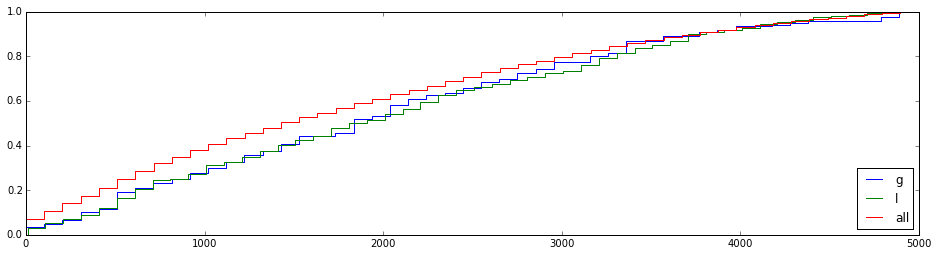

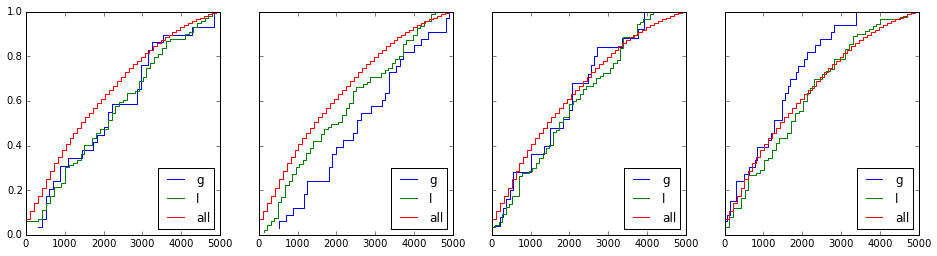

In [41]:
import statsmodels.api as sm

def plot_cdf1(sample):
    ecdf = sm.distributions.ECDF(sample)
    x = np.linspace(min(sample), max(sample))
    y = ecdf(x)
    plt.step(x, y)

def plot_cdf(samples, labels, ax):
    for i, sample in enumerate(samples):
        ecdf = sm.distributions.ECDF(sample)
        x = np.linspace(min(sample), max(sample))
        y = ecdf(x)
        ax.step(x, y, label=labels[i])
    ax.legend(loc=4)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
plot_cdf([g_ages, l_ages, all_stars_ages], ['g', 'l', 'all'], axes)

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
for i in xrange(len(teff_categories.categories)):
    plot_cdf([g_bins_ages[i], l_bins_ages[i], all_stars_ages], ['g', 'l', 'all'], axes[i])


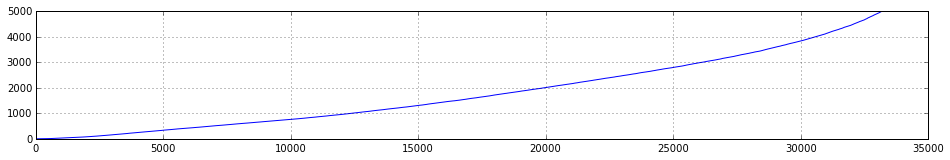

In [42]:
# from astroML.plotting import hist
# hist(g_ages, bins='knuth')

vector_dist(all_stars_ages, figsize=(16, 16))
plt.gca().set_aspect('equal')


#### Compute best bandwidth for each age-vector

In [43]:
# #######################################################################
# #          Look for best bandwidth for KDE (This was done manually)   #
# #######################################################################
# def run_grid(x, lower, upper, n=30, cv=10):
#     """ n: number of points on the grid """
#     grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': np.linspace(lower, upper, n)}, cv=cv)
#     grid.fit(x[:, None])
#     return grid

# def plot_grid_scores(grid, ax=None, title=""):
#     """ plot validation scores """
#     n = len(grid.grid_scores_)
#     x = [grid.grid_scores_[i].parameters['bandwidth'] for i in xrange(n)]
#     scores = [grid.grid_scores_[i].mean_validation_score for i in xrange(n)]
#     best_x = grid.best_params_['bandwidth']
#     if ax is None:
#         plt.plot(x, scores)
#         return
#     ax.plot(x, scores)
#     ax.set_title("{} {:.0f}".format(title, best_x))    
    

In [44]:
# # Remark: all_stars_ages might have faulty behaviour near 0.. so we take a bigger bandwidth
# best_bandwidthes_no_agelimit = {
#     "all_stars_ages": 4.5,
#     "g_ages": 215,
#     "l_ages": 160,
#     "g_bins_ages[0]": 228, 
#     "g_bins_ages[1]": 233,
#     "g_bins_ages[2]": 410,
#     "g_bins_ages[3]": 278,
#     "l_bins_ages[0]": 75,
#     "l_bins_ages[1]": 290,
#     "l_bins_ages[2]": 351,
#     "l_bins_ages[3]": 243 ,
# }

# best_bandwidthes_4000 = {
#     "all_stars": 30,  # 4.5
#     "g": 200,
#     "l": 135,
#     "g_bins0": 208, 
#     "g_bins1": 233,
#     "g_bins2": 324,
#     "g_bins3": 270,
#     "l_bins0": 335,  # 62
#     "l_bins1": 201,
#     "l_bins2": 275,
#     "l_bins3": 260 ,
# }

# # plot_grid_scores(get_best_bandwidth(l_bins_ages[3], 200, 300, 200, cv=10))

# ######################################################

# name_params = {  # sample, ax_num, lower, upper
#     "g": (g_ages, (0, 0), 150, 250),
#     "l": (l_ages, (0, 1), 100, 170),
#     "g_bins0": (g_bins_ages[0], (1, 0), 150, 220), 
#     "g_bins1": (g_bins_ages[1], (1, 1), 190, 300),
#     "g_bins2": (g_bins_ages[2], (1, 2), 270, 370),
#     "g_bins3": (g_bins_ages[3], (1, 3), 220, 330),
#     "l_bins0": (l_bins_ages[0], (2, 0), 260, 350),
#     "l_bins1": (l_bins_ages[1], (2, 1), 170, 280),
#     "l_bins2": (l_bins_ages[2], (2, 2), 220, 320),
#     "l_bins3": (l_bins_ages[3], (2, 3), 220, 320),
# }
# bws = {}

# fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, figsize=(16,8))
# fig.suptitle("GridSearchCV Bandwidth Scores (log-likelihood)", size='x-large')
# for name, params in name_params.iteritems():
#     grid = run_grid(params[0], params[2], params[3], n=100, cv=20)    
#     bws[name] = grid.best_params_['bandwidth']
#     ax = params[1]
#     plot_grid_scores(grid, ax=axes[ax[0], ax[1]], title=name)

# ## Manual changes
# bws["all_stars"] = 15
# bws["l_bins0"] = 335

#### Compute PDF for each age-vector

In [45]:
def kde_scipy(x, x_grid, bandwidth=None):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x)
    pdf = kde.evaluate(x_grid)
    
    # the bandwidth is automatically computed according to scott's rule-of-thumb (1992)
    # which is: std * 1.06*n**(-1/5)
    # (the last term is in kde.factor)
    bandwidth = x.std() * kde.factor
    
    return pdf

    
def kde_sklearn(x, x_grid, bandwidth):
    kde_skl = KernelDensity(bandwidth=bandwidth)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    pdf = np.exp(log_pdf)
    return pdf    


# ######################################################
# #            Checking that KDE works                 #
# ######################################################
# # using INTC it should the bandwidth should be around 0.3
# intc_path = "INTC.txt"
# intc = pd.read_csv(intc_path)
# def get_return_rate(df):
#     return 100*(df['Adj Close'].diff() / df['Adj Close'].shift(1))
# sample = get_return_rate(intc).dropna()
# sample = sample.values

# # fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
# # grid = run_grid(sample, 0.1, 0.5, n=50, cv=2)
# # plot_grid_scores(grid, ax=ax, title="checking, max should be ~0.3")
# # best_bandwidth = grid.best_params_['bandwidth']
# # print "Best bandwidth:", best_bandwidth

# fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 6))
# x_grid = np.linspace(sample.min(), sample.max(), 1000)

# intc_pdf = kde_sklearn(sample, x_grid=x_grid, bandwidth=0.35)
# axes[0].plot(x_grid, intc_pdf)

# intc_pdf = kde_scipy(sample, x_grid=x_grid)
# axes[1].plot(x_grid, intc_pdf)



In [46]:
x_grid = np.linspace(0, age_limit, 1000)
kde = kde_scipy # if "kde_scipy" is used, given bandwidths to kde function can be ignored. 
                # it is being automatically computed, look in kde_scipy function.


#### Set bandwidths if kde_scipy is used
name_sample = {
    "all_stars": all_stars_ages,
    "g": g_ages,
    "l": l_ages,
    "g_bins0": g_bins_ages[0],
    "g_bins1": g_bins_ages[1],
    "g_bins2": g_bins_ages[2],
    "g_bins3": g_bins_ages[3],
    "l_bins0": l_bins_ages[0],
    "l_bins1": l_bins_ages[1],
    "l_bins2": l_bins_ages[2],
    "l_bins3": l_bins_ages[3],
}
bws = {}
for name, sample in name_sample.iteritems():
    s = sample.std()
    bws[name] = s * gaussian_kde(sample).factor
######

    
all_stars_ages_pdf = kde(all_stars_ages, x_grid, bandwidth=bws['all_stars'])
# Remark: for all_stars_ages GridSearchCV gives best score for bandwidth~4.5
#         I think it's a problem because of the constraint that all values are positive
#         Therefore, There's some "faulty" behaviour close to 0, where there are also lots of samples..
#         but not that many as it looks with bandwidth=4.5

# Overall PDFs
g_ages_pdf = kde(g_ages, x_grid, bandwidth=bws['g'])
l_ages_pdf = kde(l_ages, x_grid, bandwidth=bws['l'])
# Temp bins PDFs
g_bins_ages_pdf = [None] * 4
g_bins_ages_pdf[0] = kde(g_bins_ages[0], x_grid, bandwidth=bws['g_bins0'])
g_bins_ages_pdf[1] = kde(g_bins_ages[1], x_grid, bandwidth=bws['g_bins1'])
g_bins_ages_pdf[2] = kde(g_bins_ages[2], x_grid, bandwidth=bws['g_bins2'])
g_bins_ages_pdf[3] = kde(g_bins_ages[3], x_grid, bandwidth=bws['g_bins3'])
l_bins_ages_pdf = [None] * 4
l_bins_ages_pdf[0] = kde(l_bins_ages[0], x_grid, bandwidth=bws['l_bins0'])
l_bins_ages_pdf[1] = kde(l_bins_ages[1], x_grid, bandwidth=bws['l_bins1'])
l_bins_ages_pdf[2] = kde(l_bins_ages[2], x_grid, bandwidth=bws['l_bins2'])
l_bins_ages_pdf[3] = kde(l_bins_ages[3], x_grid, bandwidth=bws['l_bins3'])

#######################################################################
#          Debias PDFs according to all_stars_pdf                     #
#######################################################################
normalize = lambda d: d / sum(d)

# all pdfs are computed on the same grid, so we just have to divide each pdf with the all_stars_pdf
debiased_g_ages_pdf = g_ages_pdf / all_stars_ages_pdf
debiased_g_ages_pdf = normalize(debiased_g_ages_pdf)

debiased_l_ages_pdf = l_ages_pdf / all_stars_ages_pdf
debiased_l_ages_pdf = normalize(debiased_l_ages_pdf)

debiased_g_bins_ages_pdf = [None] * 4
for i in xrange(4):
    debiased_g_bins_ages_pdf[i] = g_bins_ages_pdf[i] / all_stars_ages_pdf
    debiased_g_bins_ages_pdf[i] = normalize(debiased_g_bins_ages_pdf[i])
debiased_l_bins_ages_pdf = [None] * 4
for i in xrange(4):
    debiased_l_bins_ages_pdf[i] = l_bins_ages_pdf[i] / all_stars_ages_pdf
    debiased_l_bins_ages_pdf[i] = normalize(debiased_l_bins_ages_pdf[i])

#### Plot PDFs

'Comparing period'

Bigger than 7.0 days vs. Smaller than 7.0 days


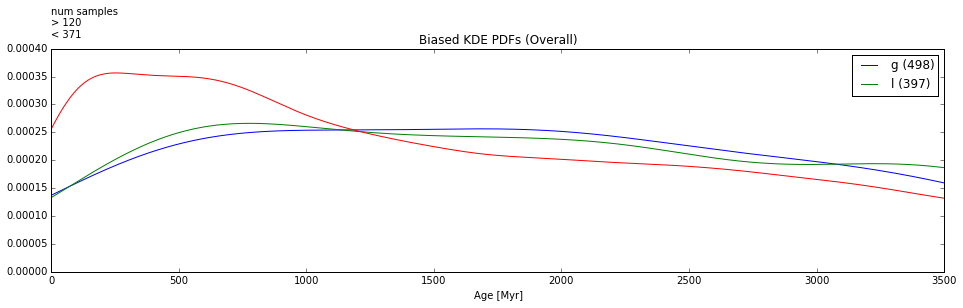

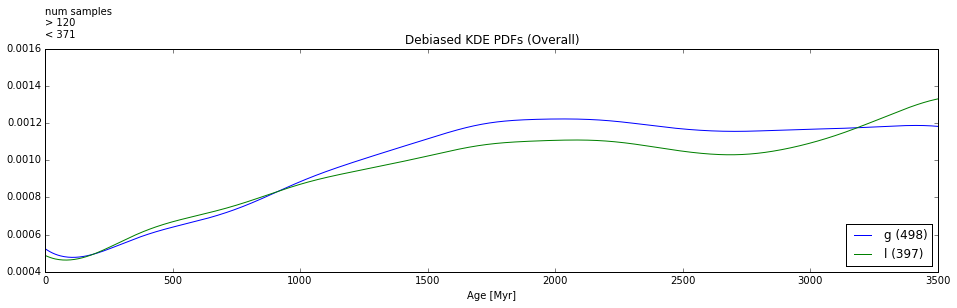

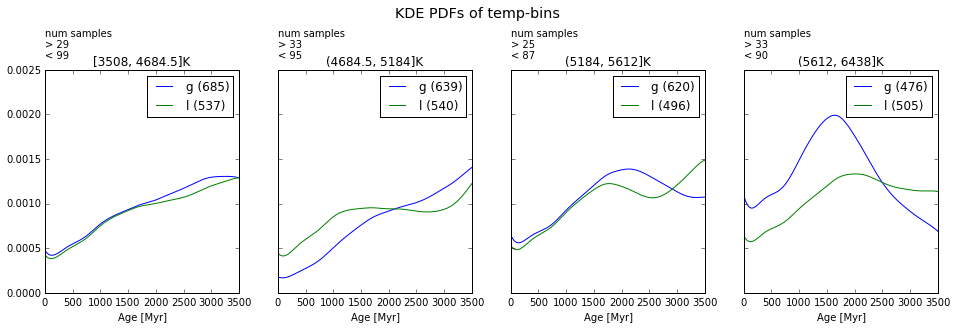

In [47]:

max_age_to_plot = 3500

display("Comparing {}".format(thresh_type))
print "Bigger than {} {} vs. Smaller than {} {}".format(threshold, thresh_unit, threshold, thresh_unit)

def plot_pdfs(g, l, sizes, bws, ax, title=""):
    ax.plot(x_grid, g, label='g ({:.0f})'.format(bws[0]))
    ax.plot(x_grid, l, label='l ({:.0f})'.format(bws[1]))
    ax.set_title(title)
    ax.set_xlabel("Age [Myr]")
    ax.set_xlim([0, max_age_to_plot])
    ax.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
    ax.annotate('> {}'.format(sizes[0]), xy=(0.00, 1.10), xycoords='axes fraction')
    ax.annotate('< {}'.format(sizes[1]), xy=(0.00, 1.05), xycoords='axes fraction')
    ax.legend()

# Overall Biased
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
plot_pdfs(g_ages_pdf, l_ages_pdf, 
          sizes=[g_ages.shape[0], l_ages.shape[0]],
          bws=[bws['g'], bws['l']],
          ax=ax, 
          title="Biased KDE PDFs (Overall)")
plt.plot(x_grid, all_stars_ages_pdf, label='all stars')
fig.savefig(os.path.join(GRAPHS_DIR, "kde_overall_biased.png"))

# Overall Debiased
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
plot_pdfs(debiased_g_ages_pdf, debiased_l_ages_pdf, 
          sizes=[g_ages.shape[0], l_ages.shape[0]], 
          bws=[bws['g'], bws['l']],
          ax=ax, 
          title="Debiased KDE PDFs (Overall)")
plt.legend(loc=4)
fig.savefig(os.path.join(GRAPHS_DIR, "kde_overall_unbiased.png"))

# Temp bins (Debiased)
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
fig.suptitle("KDE PDFs of temp-bins", size='x-large', y=1.12)
for i in xrange(len(teff_categories.categories)):
    ax = axes[i]
    plot_pdfs(debiased_g_bins_ages_pdf[i], debiased_l_bins_ages_pdf[i], 
              sizes=[g_bins_ages[i].shape[0], l_bins_ages[i].shape[0]], 
              bws=[bws['g_bins{}'.format(i)], bws['l_bins{}'.format(i)]],
              ax=ax, 
              title="{}K".format(teff_categories.categories[i]))
fig.savefig(os.path.join(GRAPHS_DIR, "kde_tempbins_unbiased.png"))

## Compute rolling windows statistics

In [48]:
###################################################################
#           Compute runnning window regarding the values          #
###################################################################

# min_window_obs_num = 30

# fig_win_size, axes_win_obs_num = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
# fig_win_size.suptitle("window-obs-num", size='xx-large', y=1.08)
# def get_rolling_window(q):
#     q = q.sort('Age')
#     rolling_df = rollBy(q.multiplicity, q.Age, stars, window=1000)
#     rolling_df.plot('mean_age', 'forward_win_size', ax=axes_win_obs_num)
#     print 'size before filter small windows:', rolling_df.shape[0]
#     rolling_df = rolling_df[rolling_df.forward_win_size > min_window_obs_num]
#     print 'size after filtering small windows:', rolling_df.shape[0]
#     return rolling_df

# print "G"
# rolling_df_g = get_rolling_window(systems_g)
# print "L"
# rolling_df_l = get_rolling_window(systems_l)

# max_age = max(rolling_df_g['mean_age'].max(), rolling_df_l['mean_age'].max())

###################################################################
#           Compute runnning window regardless of values          #
###################################################################

def get_rolling_window(q, window_size, num_ticks, min_window_obs_num, ax):
    q = q.sort('Age')
    rolling_df = roll_window_regardless_values(q.multiplicity, q.Age, stars, window_size=window_size, num_ticks=num_ticks)

    # Plot statistics for window samples num
    rolling_df.plot('mean_age', 'forward_win_size', ax=ax)
    print 'size before filter small windows:', rolling_df.shape[0]
    ax.axhline(y=min_window_obs_num, color='r')
    rolling_df = rolling_df[rolling_df.forward_win_size > min_window_obs_num]
    print 'size after filtering small windows:', rolling_df.shape[0]
    
    return rolling_df



# ###################################################################
# #           Compute for Overall                                   #
# ###################################################################

# min_window_obs_num = 30
# window_size = 500
# num_ticks = 1000

# fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
# fig.suptitle("window-obs-num", size='xx-large', y=1.00)
# print "G"
# rolling_df_g = get_rolling_window(systems_g, window_size, num_ticks, min_window_obs_num, ax=ax)
# print "L"
# rolling_df_l = get_rolling_window(systems_l, window_size, num_ticks, min_window_obs_num, ax=ax)


# ###################################################################
# #           Compute for bins                                      #
# ###################################################################

# min_window_obs_num = 20
# window_size = 1500
# num_ticks = 400


# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
# fig.suptitle("window-obs-num", size='xx-large', y=1.00)
# teff_rollings = []
# for teff_bin in xrange(len(teff_categories.categories)):
#     qg = systems_g[systems_g.teff_bins==teff_bin+1]
#     ql = systems_l[systems_l.teff_bins==teff_bin+1]

#     ax = axes[teff_bin]
#     g = get_rolling_window(qg, window_size, num_ticks, min_window_obs_num, ax=ax)
#     l = get_rolling_window(ql, window_size, num_ticks, min_window_obs_num, ax=ax)
    
#     teff_rollings.append((g, l))


## Compare frequency, multiplicity - overall

In [49]:
def compare_two_sides(title, g, l, yvalues='mean', saveas='', **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4))
    g.plot('mean_age', yvalues, ax=ax, label='{} > {} {}'.format(thresh_type, threshold, thresh_unit))
    l.plot('mean_age', yvalues, ax=ax, label='{} < {} {}'.format(thresh_type, threshold, thresh_unit))
    ax.set_xlabel("mean age [Myr]")
#     # compute ks-score
#     score = ks_2samp(g[yvalues], l[yvalues]).pvalue
#     title = "{:s}\nscore: {}".format(title, score)
    
    fig.suptitle(title, size='xx-large', y=1.00)
    fig.savefig(os.path.join(GRAPHS_DIR, saveas))
#     plt.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
#     plt.annotate('> {}'.format(g.shape[0]), xy=(0.00, 1.10), xycoords='axes fraction')
#     plt.annotate('< {}'.format(l.shape[0]), xy=(0.00, 1.05), xycoords='axes fraction')

    
def compare_two_sides_bins(title, teff_rollings, yvalues='mean', saveas='', **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
    fig.suptitle(title, size='xx-large', y=1.08)

    for teff_bin in xrange(len(teff_categories.categories)):
        ax = axes[teff_bin]
        
        g = teff_rollings[teff_bin][0]
        l = teff_rollings[teff_bin][1]

        g.plot('mean_age', yvalues, ax=ax, label='{} > {} {}'.format(thresh_type, threshold, thresh_unit))
        l.plot('mean_age', yvalues, ax=ax, label='{} < {} {}'.format(thresh_type, threshold, thresh_unit))
        
        ax.set_title("{}K".format(teff_categories.categories[teff_bin]))
        ax.set_xlabel("mean age [Myr]")
        # ax.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
#         ax.annotate('> {}'.format(g.shape[0]), xy=(0.00, 1.10), xycoords='axes fraction')
#         ax.annotate('< {}'.format(l.shape[0]), xy=(0.00, 1.05), xycoords='axes fraction')
    
    fig.savefig(os.path.join(GRAPHS_DIR, saveas))

# rolling_df.plot('mean_age', 'ks-score', title='moving window KS score', logy=True)
compare_two_sides('mean multiplicity', rolling_df_g, rolling_df_l, 'mean', 'comparison_multiplicity.png')
compare_two_sides_bins('mean multiplicity', teff_rollings, 'mean', 'comparison_multiplicity_temp_bins.png')

compare_two_sides('planets frequency', rolling_df_g, rolling_df_l, 'planets-freq', 'comparison_planet_frequency.png')
compare_two_sides_bins('planets frequency', teff_rollings, 'planets-freq', 'comparison_planet_frequency_temp_bins.png')

compare_two_sides('systems frequency', rolling_df_g, rolling_df_l, 'systems-freq', 'comparison_system_frequency.png')
compare_two_sides_bins('systems frequency', teff_rollings, 'systems-freq', 'comparison_system_frequency_temp_bins.png')

compare_two_sides('ks-score', rolling_df_g, rolling_df_l, 'ks-score', 'comparison_ks.png')
compare_two_sides_bins('ks-score', teff_rollings, 'ks-score', 'comparison_ks_temp_bins.png')


NameError: name 'rolling_df_g' is not defined

### Make Animations

In [ ]:
# import numpy as np
# from matplotlib import pyplot as plt
# from matplotlib import animation


# fig = plt.figure()
# ax = plt.axes(xlim=(0, 3500), ylim=(0, 0.03))
# line, = ax.plot([], [], lw=2)

# ### Parameters ###
# min_window_obs_num = 30
# window_size = 500
# num_ticks = 1000

# def get_rolling_window(q, window_size, num_ticks, min_window_obs_num):
#     q = q.sort('Age')
#     rolling_df = roll_window_regardless_values(q.multiplicity, q.Age, stars, window_size=window_size, num_ticks=num_ticks)
#     rolling_df = rolling_df[rolling_df.forward_win_size > min_window_obs_num]
#     return rolling_df

# def animate(frame):

#     print ">>>>>>>>>>", frame
#     thresholds = [6.7, 7, 7.3]
    
#     ### Define the threshold ###
#     threshold = thresholds[frame]
#     thresh_type = 'period'
#     thresh_unit = 'days'
#     yvalues = 'planets-freq'
#     title = 'planets frequency'
    
#     # define df for planets smaller-bigger than threshold
#     pg = p[p.koi_period > threshold]
#     pl = p[p.koi_period < threshold]
#     # define systems-df for each planets-df
#     systems_g = pg[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
#     systems_g['multiplicity'] = pg.groupby('KIC').size()
#     systems_g['teff_bins'] = digitize(systems_g.Teff, teff_qbins)
#     systems_l = pl[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
#     systems_l['multiplicity'] = pl.groupby('KIC').size()
#     systems_l['teff_bins'] = digitize(systems_l.Teff, teff_qbins)
#     ### Compute rolling windows ###
#     g = get_rolling_window(systems_g, window_size, num_ticks, min_window_obs_num)
#     l = get_rolling_window(systems_l, window_size, num_ticks, min_window_obs_num)

#     x = g['mean_age'].values
#     y = g[yvalues].values
#     line.set_data(x, y)
#     return line,    
        
# #     im1 = g.plot('mean_age', yvalues, label='{} > {} {}'.format(thresh_type, threshold, thresh_unit))
# #     im2 = l.plot('mean_age', yvalues, label='{} < {} {}'.format(thresh_type, threshold, thresh_unit))
# #     plt.set_xlabel("mean age [Myr]")
# #     plt.title(title, size='xx-large', y=1.00)
    
# #     plt.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
# #     plt.annotate('> {}'.format(g.shape[0]), xy=(0.00, 1.10), xycoords='axes fraction')
# #     plt.annotate('< {}'.format(l.shape[0]), xy=(0.00, 1.05), xycoords='axes fraction')

    
# def init():
#     line.set_data([], [])
#     return line,
    
# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=3, interval=1000, blit=True)

# # anim.save('planets-freq_threshold.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

# # plt.show()




In [ ]:
# #run animation
# zz = ims
# fig = plt.figure()
# ani = animation.ArtistAnimation(fig,ims, interval=50,blit=False)
# plt.show()

# # anim = animation.FuncAnimation(fig, animate, init_func=init,
# #                                frames=200, interval=20, blit=True)
# ani.save('planets-freq_threshold.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

In [ ]:
# import numpy as np
# from matplotlib import pyplot as plt
# from matplotlib import animation


# ### Parameters ###
# min_window_obs_num = 20
# window_size = 1500
# num_ticks = 400

# ### Define the thrshold ###
# threshold = 7
# thresh_type = 'period'
# thresh_unit = 'days'
# # define df for planets smaller-bigger than threshold
# pg = p[p.koi_period > threshold]
# pl = p[p.koi_period < threshold]
# # define systems-df for each planets-df
# systems_g = pg[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
# systems_g['multiplicity'] = pg.groupby('KIC').size()
# systems_g['teff_bins'] = digitize(systems_g.Teff, teff_qbins)
# systems_l = pl[['KIC', 'Teff', 'Age']].groupby('KIC').agg(max)
# systems_l['multiplicity'] = pl.groupby('KIC').size()
# systems_l['teff_bins'] = digitize(systems_l.Teff, teff_qbins)

# ### Compute rolling windows ###
# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
# fig.suptitle("window-obs-num", size='xx-large', y=1.00)
# teff_rollings = []
# for teff_bin in xrange(len(teff_categories.categories)):
#     qg = systems_g[systems_g.teff_bins==teff_bin+1]
#     ql = systems_l[systems_l.teff_bins==teff_bin+1]

#     ax = axes[teff_bin]
#     g = get_rolling_window(qg, window_size, num_ticks, min_window_obs_num, ax=ax)
#     l = get_rolling_window(ql, window_size, num_ticks, min_window_obs_num, ax=ax)
    
#     teff_rollings.append((g, l))


# ### Compute the plots.. ###
# def compare_two_sides_bins(title, teff_rollings, yvalues='mean', saveas='', **kwargs):
#     fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))
#     fig.suptitle(title, size='xx-large', y=1.08)

#     for teff_bin in xrange(len(teff_categories.categories)):
#         ax = axes[teff_bin]
        
#         g = teff_rollings[teff_bin][0]
#         l = teff_rollings[teff_bin][1]

#         g.plot('mean_age', yvalues, ax=ax, label='{} > {} {}'.format(thresh_type, threshold, thresh_unit))
#         l.plot('mean_age', yvalues, ax=ax, label='{} < {} {}'.format(thresh_type, threshold, thresh_unit))
        
#         ax.set_title("{}K".format(teff_categories.categories[teff_bin]))
#         ax.set_xlabel("mean age [Myr]")
#         # ax.annotate('num samples', xy=(0.00, 1.15), xycoords='axes fraction')
#         ax.annotate('> {}'.format(g.shape[0]), xy=(0.00, 1.10), xycoords='axes fraction')
#         ax.annotate('< {}'.format(l.shape[0]), xy=(0.00, 1.05), xycoords='axes fraction')
    
#     fig.savefig(os.path.join(GRAPHS_DIR, saveas))

# compare_two_sides_bins('planets frequency', teff_rollings, 'planets-freq', 'comparison_planet_frequency_temp_bins.png')

    
    
# def init():


    
# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4))


# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=200, interval=20, blit=True)
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
